<a href="https://colab.research.google.com/github/olysenko1/Machine_learning/blob/master/Wine_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Wine Prices from Textual Descriptions




In [0]:
from google.colab import files
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt




import ktrain
from ktrain import text

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


## Data importing, preprocessing

This project is done using google colab, thus there is a need for a special way of data uploading using google.colab and io libraries. After data is uploaded it is put into the dataframe.

In [10]:
uploaded = files.upload()

Saving winemag-data_first150k.csv to winemag-data_first150k.csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['winemag-data_first150k.csv']),sep = ",", index_col=0)

Let's take a look at how our 5 random observations are represented in our dataset

In [15]:
df = df.sample(frac=1., random_state=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
8486,Italy,"Made entirely from Nero d'Avola, this opens wi...",Violino,89,20.0,Sicily & Sardinia,Vittoria,NaN,Nero d'Avola,Paolo Calì
137012,Argentina,"Starts out smoky and seemingly ripe, but the n...",NaN,81,10.0,Mendoza Province,Mendoza,NaN,Syrah,Acordeón
92051,Bulgaria,"A curious bouquet of lemongrass, pine needles ...",NaN,83,10.0,Bulgaria,NaN,NaN,Traminer,Targovishte
5281,Spain,Red-fruit and citrus aromas create an astringe...,NaN,84,12.0,Northern Spain,Ribera del Duero,NaN,Tempranillo,Condado de Oriza
132014,France,"93-95 Barrel sample. A fine, fresh, berry flav...",Barrel sample,94,NaN,Bordeaux,Pessac-Léognan,NaN,Bordeaux-style Red Blend,Château Picque Caillou


In [16]:
df.shape

(150930, 10)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150930 entries, 8486 to 43567
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      150925 non-null  object 
 1   description  150930 non-null  object 
 2   designation  105195 non-null  object 
 3   points       150930 non-null  int64  
 4   price        137235 non-null  float64
 5   province     150925 non-null  object 
 6   region_1     125870 non-null  object 
 7   region_2     60953 non-null   object 
 8   variety      150930 non-null  object 
 9   winery       150930 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 12.7+ MB


What is the percentage of the missing values in our dataset?

In [18]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
region_2,89977,59.615053
designation,45735,30.302127
region_1,25060,16.603724
price,13695,9.073743
province,5,0.003313
country,5,0.003313
winery,0,0.000000
variety,0,0.000000
points,0,0.000000
description,0,0.000000


Clean dataset from price missing values 

In [43]:
df = df[pd.notnull(df['price'])]
df = df[pd.notnull(df['variety'])]
df['price'].describe()

count    77275.000000
mean        34.785597
std         38.985483
min          4.000000
25%         16.000000
50%         25.000000
75%         42.000000
max       2300.000000
Name: price, dtype: float64

We see that we have largely unbalanced dataset, mostly represented with cheap wine. 75% of wine in the dataset is cheaper than 40$. Thus, we want to exclude exteremely rare wine from our dataset. This is done using variety column. If the wine occurs in the dataset less than 500 times - it's considered to be very rare and will bias our predictions. 

In [0]:
variety_threshold = 500 # Variety of wine that occurs in the dataset less 500 times will be removed.
value_counts = df['variety'].value_counts()
to_remove = value_counts[value_counts <= variety_threshold].index
df.replace(to_remove, np.nan, inplace=True)

Remove duplicates based on the description 

In [45]:
df=df.drop_duplicates(['description'])
df=df.reset_index(drop=True)
df.describe 

<bound method NDFrame.describe of          country  ...            winery
0      Argentina  ...          Acordeón
1          Spain  ...  Condado de Oriza
2          Italy  ...  Pagani de Marchi
3          Chile  ...        Lapostolle
4             US  ...       Turner Road
...          ...  ...               ...
77270         US  ...            Lynmar
77271         US  ...            Girard
77272         US  ...    Michael Pozzan
77273         US  ...           Naggiar
77274         US  ...            Bonair

[77275 rows x 10 columns]>

##EDA

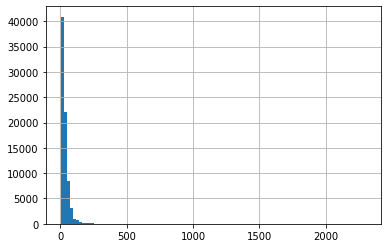

In [46]:
df['price'].hist(bins=100)


The unbalancess obviously remains. Let's take a closer look on number of wines per price

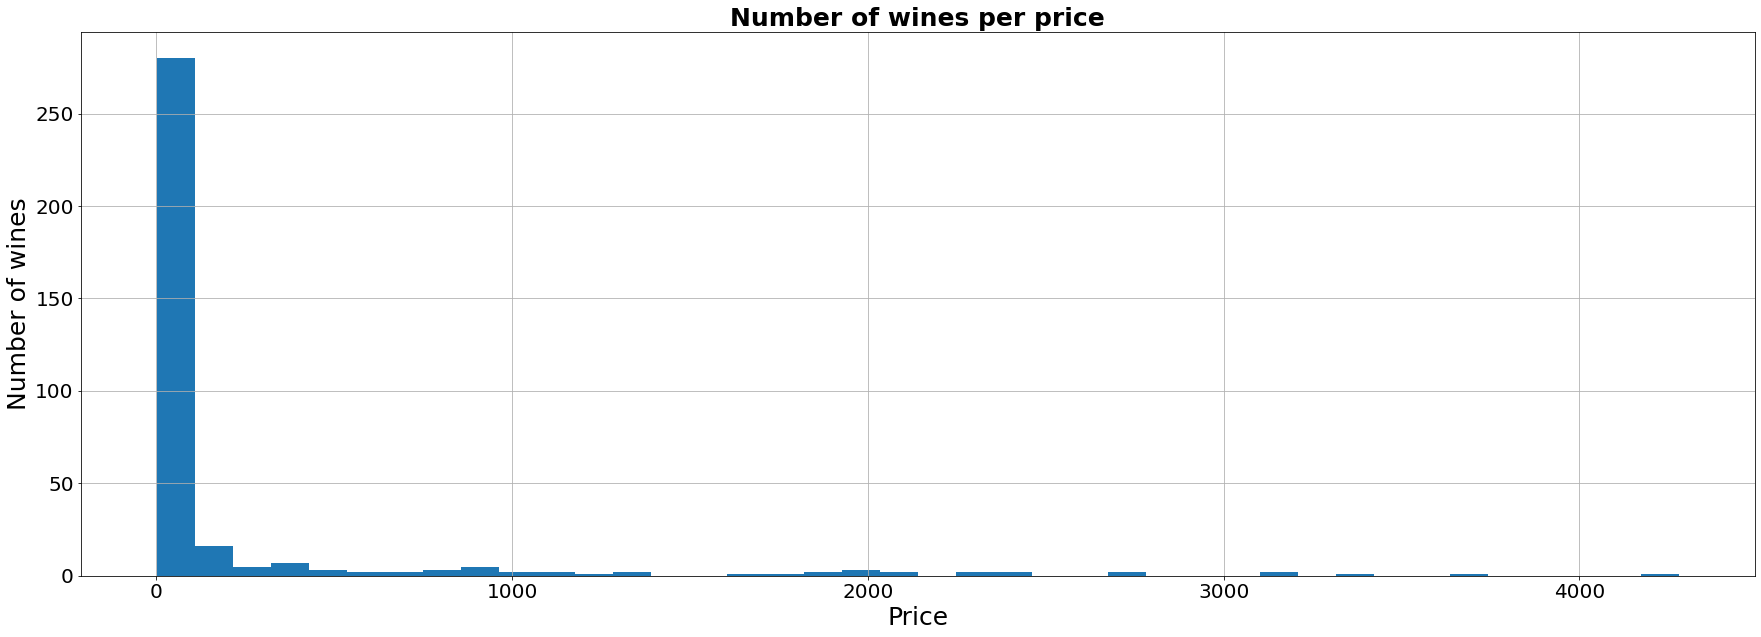

In [47]:
dp = df[['description','price']]
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Number of wines per price', fontweight="bold", size=25) # Title
ax.set_ylabel('Number of wines', fontsize = 25) # Y label
ax.set_xlabel('Price', fontsize = 25) # X label
dp.groupby(['price']).count()['description'].hist(bins = 40)

##Model selection and analysis 

### **Ktrain text regression**

Firstly, I use text regression to predict price of the wine based on the description and variety. 

In [49]:
# Split data into train and test
train_size = int(len(df) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

# Train features
description_train = df['description'][:train_size]
variety_train = df['variety'][:train_size]

# Train labels
labels_train = df['price'][:train_size]

# Test features
description_test = df['description'][train_size:]
variety_test = df['variety'][train_size:]

# Test labels
labels_test = df['price'][train_size:]

x_train = description_train.values
y_train = labels_train.values
x_test = description_test.values
y_test = labels_test.values


Train size: 61820
Test size: 15455


In [50]:
trn, val, preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                          x_test=x_test, y_test=y_test)
                                    

task: text regression (supply class_names argument if this is supposed to be classification task)
language: en
Word Counts: 29815
Nrows: 61820
61820 train sequences
train sequence lengths:
	mean : 41
	95percentile : 62
	99percentile : 74
x_train shape: (61820,400)
y_train shape: (61820,)


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:468: UserWarning: Task is being treated as TEXT REGRESSION because class_names argument was not supplied. If this is incorrect, supply class_names argument.
  'If this is incorrect, supply class_names argument.')


15455 test sequences
test sequence lengths:
	mean : 41
	95percentile : 61
	99percentile : 73
x_test shape: (15455,400)
y_test shape: (15455,)


In [51]:
text.print_text_regression_models()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
linreg: linear text regression using a trainable Embedding layer
bigru: Bidirectional GRU with pretrained English word vectors [https://arxiv.org/abs/1712.09405]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face [https://arxiv.org/abs/1910.01108]


In [55]:
model = text.text_regression_model('linreg', train_data=trn, preproc=preproc)
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=128)

maxlen is 400
done.


In [56]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Train on 61820 samples
Epoch 1/1024
61820/61820 [==============================] - 2s 39us/sample - loss: 2724.6574 - mae: 34.5872
Epoch 2/1024
61820/61820 [==============================] - 2s 35us/sample - loss: 2655.4625 - mae: 33.6222
Epoch 3/1024
61820/61820 [==============================] - 2s 35us/sample - loss: 1627.2894 - mae: 19.6437
Epoch 4/1024
41728/61820 [===================>..........] - ETA: 0s - loss: 1609.3530 - mae: 22.7957

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


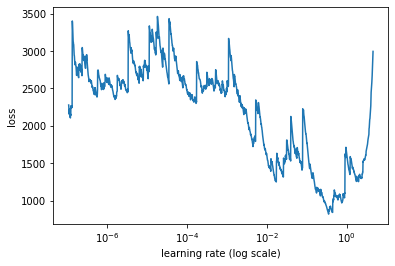

In [57]:
learner.lr_plot()

In [69]:
learner.fit_onecycle(5e-3, 5)
 #I'm not sure I got it perfectly, reach out for more 



begin training using onecycle policy with max lr of 0.005...
Train on 61820 samples, validate on 15455 samples
Epoch 1/5
61820/61820 [==============================] - 2s 39us/sample - loss: 881.9612 - mae: 13.5936 - val_loss: 1128.3765 - val_mae: 18.3080
Epoch 2/5
61820/61820 [==============================] - 2s 40us/sample - loss: 882.9655 - mae: 13.6250 - val_loss: 1129.9293 - val_mae: 18.2499
Epoch 3/5
61820/61820 [==============================] - 3s 43us/sample - loss: 883.6555 - mae: 13.6441 - val_loss: 1130.4529 - val_mae: 18.2401
Epoch 4/5
61820/61820 [==============================] - 3s 42us/sample - loss: 882.1523 - mae: 13.5975 - val_loss: 1129.2862 - val_mae: 18.3100
Epoch 5/5
61820/61820 [==============================] - 3s 41us/sample - loss: 880.5166 - mae: 13.5872 - val_loss: 1129.6004 - val_mae: 18.2925


Current MAE is around 18 which means our model's predictions are about $18 biased on average. 

In [71]:
learner.view_top_losses(n=3, preproc=preproc)


----------
id:8392 | loss:712990.56 | true:980.0 | pred:135.61)

this was a great vintage port year and this white port which was bottled in 2015 has hints of the firm tannins and structure that marked out the year it also has preserved an amazing amount of freshness still suggesting orange marmalade flavors these are backed up by the fine concentrated old wood tastes the wine is of course ready to drink
----------
id:522 | loss:595027.2 | true:850.0 | pred:78.62)

while there is certainly plenty of wood here the wine has weight and impressive concentration for the year the tannins are still brooding away giving a dark firm character to the wine blackberry fruits and acidity are there but still well buried in the tannins
----------
id:6890 | loss:497462.44 | true:848.0 | pred:142.69)

full of ripe fruit opulent and concentrated this is a fabulous and impressive wine it has a beautiful line of acidity balanced with ripe fruits the wood aging is subtle just a hint of smokiness and toast 

##Random Forest

RAM died, consider changing price variable. Will be really hard to classify using existing set-up.

In [0]:
x = df['description']
y = df['price']

vectorizer = TfidfVectorizer()
vectorizer.fit(x)
x = vectorizer.transform(x)

In [84]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
# Testing the model on 20% of the data
predictions = rfc.predict(x_test)
print(classification_report(y_test, predictions))

KeyboardInterrupt: ignored